In [1]:
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import axcgnss as axg


In [35]:
# Read results 
with open('../all_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)
all_results = pd.DataFrame(all_results)

In [4]:
def select_data(df, sampling_frequency, quantization, cn0):

    _df = df[df['sampling_frequency'].eq(sampling_frequency) & df['quantization'].eq(quantization) & df['cn0_target_dB'].eq(cn0)]
    _df = _df.dropna(axis=1, how='all')

    return _df 

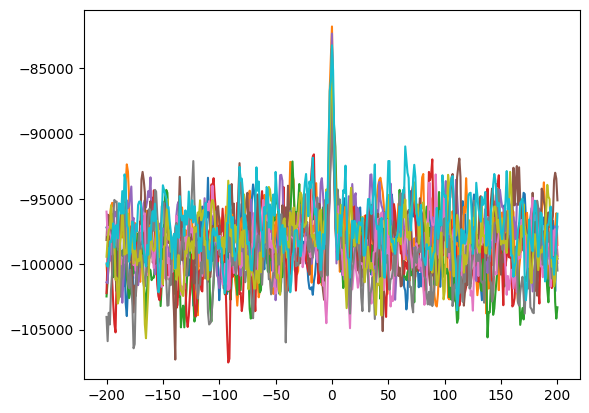

In [40]:
df = select_data(all_results, 4092000.0, 8, 40)
for index, row in df.iterrows():
    plt.plot(row['corr_lags'], row['axc_corr_mul8s_1KX5'])
#plt.xlim((-20,20))

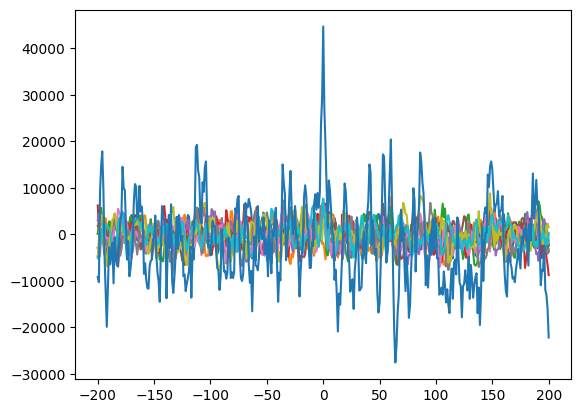

In [11]:
df = select_data(all_results, 4092000.0, 8, 30)
coherent_integration = np.zeros(401)
for index, row in df.iterrows():
    plt.plot(row['corr_lags'], row['axc_corr_mul8s_1L12'])
    coherent_integration += row['axc_corr_mul8s_1L12']
    lags = row['corr_lags']
plt.plot(lags, coherent_integration)

CN0: 30, 9.30158
CN0: 30, 9.65497
CN0: 30, -3.34128
CN0: 30, 3.46390
CN0: 30, 8.63512
CN0: 30, 7.81886
CN0: 30, -3.86325
CN0: 30, 3.97283
CN0: 30, 6.41047
CN0: 30, 2.47567


/mnt/d/Projects/Navigation/MyCode/axcgnss/Simulations/axcgnss.py:292: RuntimeWarning: invalid value encountered in log10
  return 10 * np.log10(value_linear)


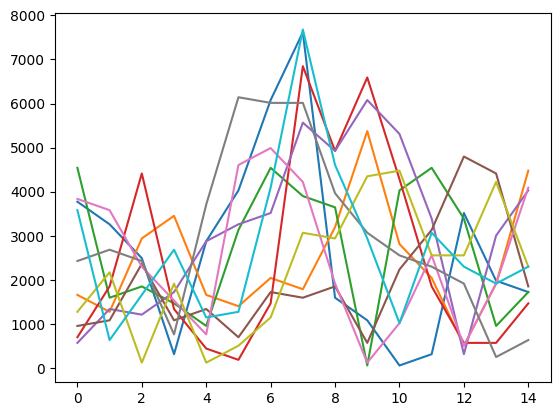

In [36]:
samplingFrequency = 4092000.0
bits = 8
cn0 = 30
df = select_data(all_results,samplingFrequency, bits, cn0)
plt.figure()
idx = 0
for index, row in df.iterrows():
    corr = np.abs(row['axc_corr_mul8s_1L12'])

    # Get the max peak
    #maxPeakIdx = np.argmax(np.abs(correlation))
    maxPeakIdx = 200 # Defined constant since it is always the same index
    peak = correlation[maxPeakIdx]**2

    correlation = np.abs(corr)#/corr[maxPeakIdx]
    samplingFrequency = 4092000.0
    samplesPerChip = round(samplingFrequency / axg.GPS_L1CA_CODE_FREQ)
    
    # Get the mean outside the peak
    mask = np.ones(len(correlation), dtype=bool)
    mask[:maxPeakIdx-2*samplesPerChip+1] = False
    mask[maxPeakIdx+2*samplesPerChip:] = False
    noise = np.mean(np.abs(correlation[~mask])**2)
    snr = axg.getPowerdB((peak - noise) / noise)
    snr = (peak - noise) / noise
    snr = axg.getPowerdB(peak) - axg.getPowerdB(noise)
    
    plt.plot(correlation[mask])
    print(f"CN0: {cn0}, {snr.mean():.5f}") 
    


In [41]:

def getPostCorrelationSNR(correlation, samplingFrequency, idxPeak):
    samplesPerChip = round(samplingFrequency / axg.GPS_L1CA_CODE_FREQ)

    correlation = np.abs(correlation)

    # Get the max peak
    peak = correlation[idxPeak]**2

    # Get the mean outside the peak
    mask = np.ones(len(correlation), dtype=bool)
    mask[:idxPeak-2*samplesPerChip] = False
    mask[idxPeak+2*samplesPerChip:] = False
    noise = np.mean(np.abs(correlation[~mask])**2)

    # Compute SNR (from Simona) - Problem when noise > peak, lead to NaN values
    # snr = (peak - noise) / noise
    # snr = axg.getPowerdB(snr)
    
    # Compute SNR - does not remove the noise part in the peak, but at least can show negative SNR
    snr = axg.getPowerdB(peak) - axg.getPowerdB(noise)

    return snr

mean_snr = []
for cn0 in range(30, 60, 5):
    df = select_data(all_results, 4092000.0, 8, cn0)
    snr = []
    for index, row in df.iterrows():
        corr = np.abs(row['axc_corr_mul8s_1L12'])
        snr.append(getPostCorrelationSNR(corr, 4092000.0, np.argmax(corr)))
    snr = np.array(snr)
    mean_snr.append(np.nanmean(snr))
    print(f"CN0: {cn0}, {np.nanmean(snr):.5f}")

CN0: 30, 9.70707
CN0: 35, 10.86132
CN0: 40, 14.59628
CN0: 45, 19.68678
CN0: 50, 23.93338
CN0: 55, 27.93973


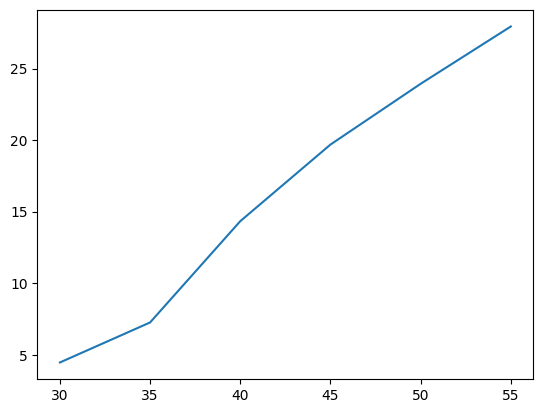

In [39]:
plt.figure()
plt.plot(range(30, 60, 5), mean_snr)

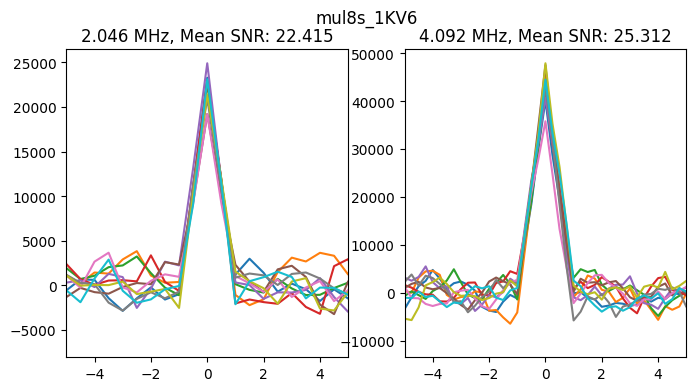

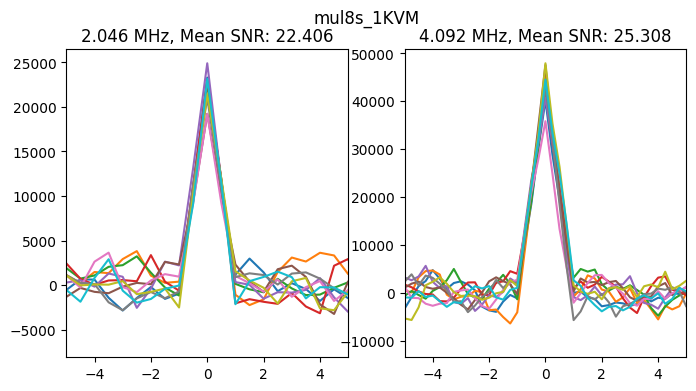

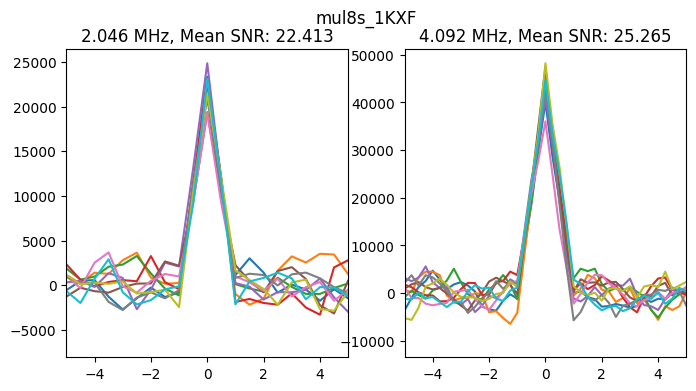

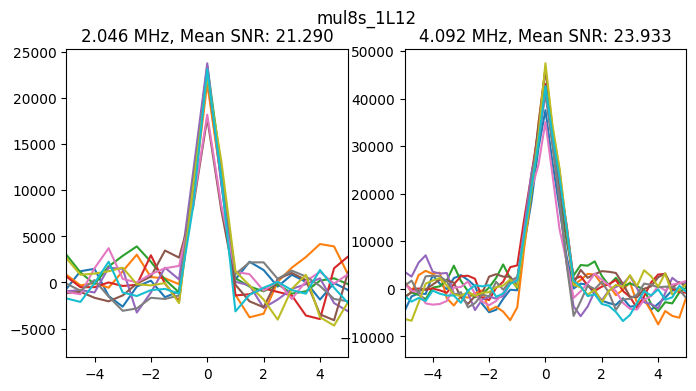

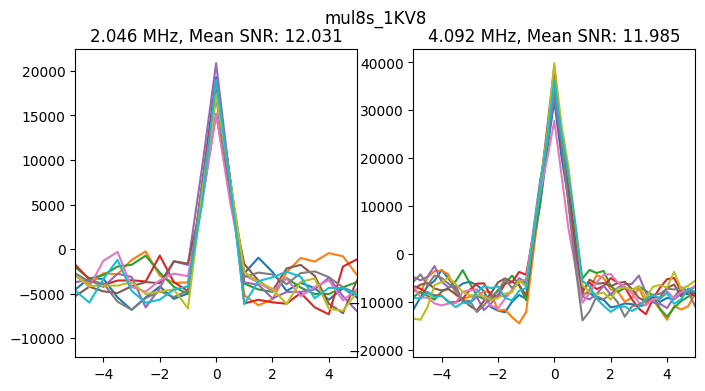

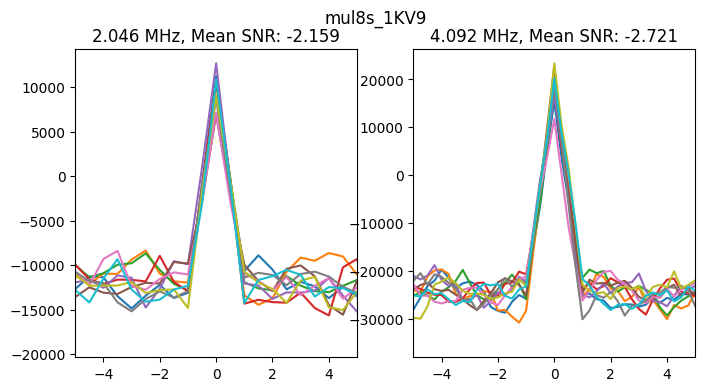

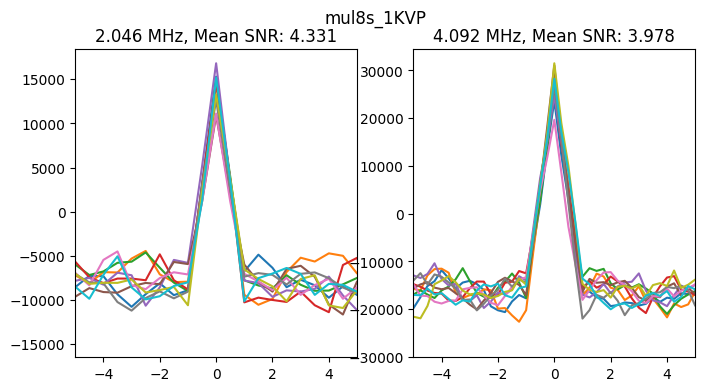

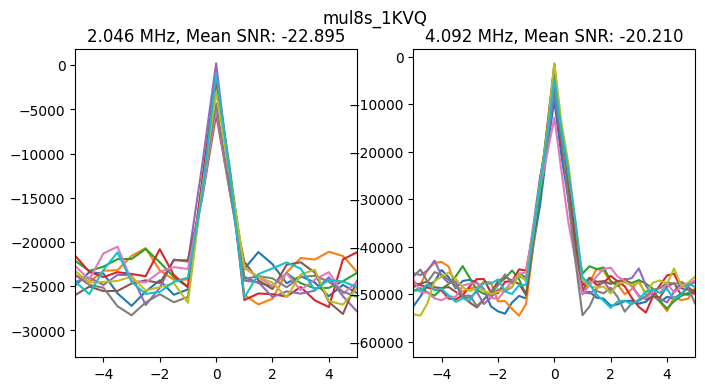

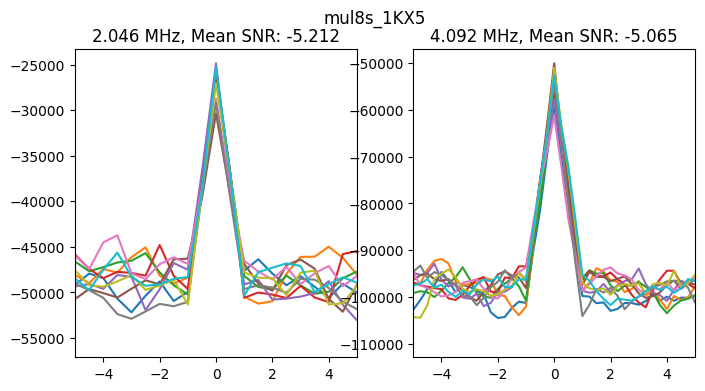

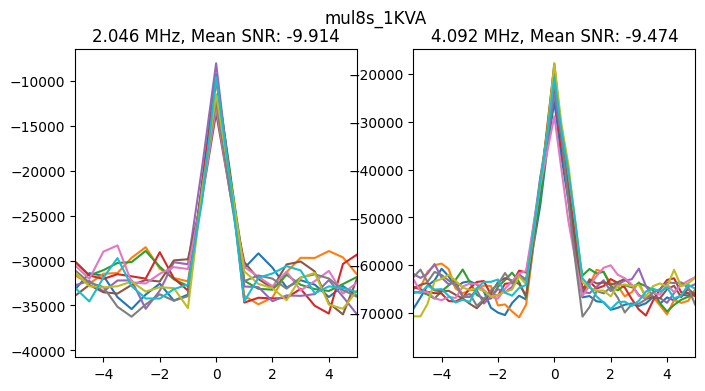

In [48]:
axc_mult_list = list(axg.EAL_MULTIPLIERS_8BIT_SIGNED.keys())
sf_list = np.array([2, 4]) * axg.GPS_L1CA_CODE_FREQ
cn0 = 50

for axc_mult in axc_mult_list:
    fig, axs = plt.subplots(1,2, figsize=(8, 4), facecolor='w', edgecolor='k')
    fig.suptitle(axc_mult)
    i = 0
    for sf in sf_list:
        samplesPerChip = round(sf / axg.GPS_L1CA_CODE_FREQ)
        df = select_data(all_results, sf, 8, cn0)
        snr = []
        for index, row in df.iterrows():
            # corr = np.abs(row[f'axc_corr_{axc_mult}'])
            corr = row[f'axc_corr_{axc_mult}']
            axs[i].plot(row['corr_lags']/samplesPerChip, corr)
            snr.append(getPostCorrelationSNR(corr, sf, idxPeak=200))
        snr = np.array(snr)
        axs[i].set_xlim((-5,5))
        axs[i].set_title(f"{sf/1e6:.3f} MHz, Mean SNR: {snr.mean():.3f}")
        i += 1
    

,mul8s_1KV6,mul8s_1KVM,mul8s_1KXF,mul8s_1L12,mul8s_1KV8,mul8s_1KV9,mul8s_1KVP,mul8s_1KVQ,mul8s_1KX5,mul8s_1KVA
30,5.436836,5.491178,5.434093,4.461411,-12.910283,-2.246229,-3.637003,-0.985866,-0.470068,-0.752375
35,10.237745,10.250572,10.231827,7.257898,-19.146332,-3.503945,-6.288372,-1.542083,-0.720236,-1.117213
40,16.05144,16.053842,15.98491,14.33397,-3.834353,-7.431978,-18.238722,-2.939354,-1.344413,-2.104592
45,20.915118,20.913456,20.862929,19.686778,5.793887,-23.190984,-5.956687,-6.446625,-2.610407,-4.31303
50,25.312276,25.307829,25.264717,23.933383,11.984609,-2.720716,3.978089,-20.209951,-5.065405,-9.474384
55,28.77765,28.775075,28.736864,27.939726,16.915576,5.35069,10.16775,-7.161257,-11.251679,-23.100152


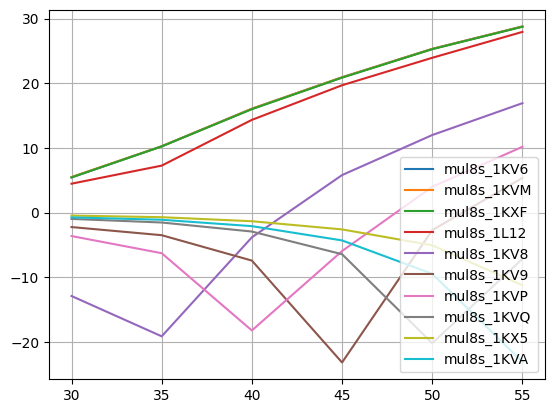

In [42]:
cn0_list = range(30, 60, 5)
axc_mult_list = list(axg.EAL_MULTIPLIERS_8BIT_SIGNED.keys())
sf = 4 * axg.GPS_L1CA_CODE_FREQ

snr = {'axc': axc_mult_list}
for cn0 in cn0_list:
    snr_mean = []
    for axc_mult in axc_mult_list:
        df = select_data(all_results, sf, 8, cn0)
        _snr = []
        for index, row in df.iterrows():
            corr = row[f'axc_corr_{axc_mult}']
            _snr.append(getPostCorrelationSNR(corr, sf, 200))
        _snr = np.array(_snr)
        snr_mean.append(np.nanmean(_snr))
        snr[f'{cn0}'] = snr_mean
snr = pd.DataFrame(snr).T
snr = snr.rename(columns=snr.iloc[0]).iloc[1:]
snr.plot(grid=True)
snr

,mul16s_HG4,mul16s_GQU,mul16s_GQV,mul16s_HF7,mul16s_GRU,mul16s_GSM,mul16s_HG8,mul16s_HFB,mul16s_GV3
30,1.231208,1.231222,1.21125,1.364828,0.724665,1.231055,1.383376,1.41979,1.23328
35,10.933859,10.933824,10.877494,11.505096,9.300413,10.933985,11.542822,11.614206,10.92896
40,36.932554,36.932717,36.820212,37.653299,33.261065,36.931516,37.722596,37.846228,36.930704
45,95.756168,95.756402,95.597157,96.048242,89.70312,95.754588,96.134506,96.281944,95.71225
50,314.293776,314.292061,313.730139,316.995388,293.679947,314.281479,317.254947,317.683971,314.293895
55,684.937044,684.935787,683.563656,686.384011,640.29364,684.930066,687.535605,689.700422,684.914839


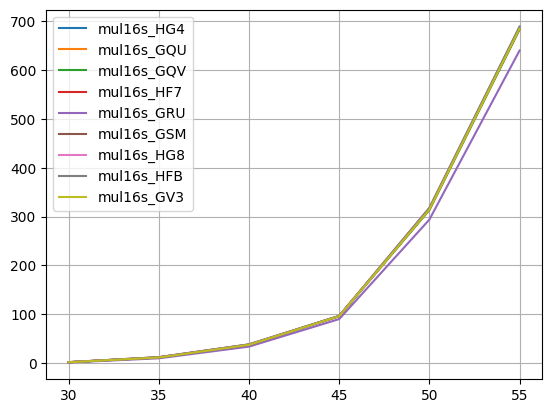

In [24]:
cn0_list = range(30, 60, 5)
axc_mult_list = list(axg.EAL_MULTIPLIERS_16BIT_SIGNED.keys())
sf = 4 * axg.GPS_L1CA_CODE_FREQ

snr = {'axc': axc_mult_list}
for cn0 in cn0_list:
    snr_mean = []
    for axc_mult in axc_mult_list:
        df = select_data(all_results, sf, 16, cn0)
        _snr = []
        for index, row in df.iterrows():
            corr = row[f'axc_corr_{axc_mult}']
            _snr.append(getPostCorrelationSNR(corr, sf, 200))
        _snr = np.array(_snr)
        snr_mean.append(np.nanmean(_snr))
        snr[f'{cn0}'] = snr_mean
snr = pd.DataFrame(snr).T
snr = snr.rename(columns=snr.iloc[0]).iloc[1:]
snr.plot(grid=True)
snr